plot facebook data in a 2D Histogramm

In [4]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from utils import load_stops
from scipy import signal
from utils import *
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d, fftconvolve
import numpy as np
import math as m
import matplotlib.pyplot as plt
import os



In [5]:
# read population
df = pd.read_csv("pop_ger.csv", sep = ",", names = ["x","y","weight"], skiprows = 1)

# read coordinates of stop
df_coordinates = load_stops("GER_Saxony_Leipzig")

minlat = df_coordinates["stop_lat"].min()
maxlat = df_coordinates["stop_lat"].max()
minlon = df_coordinates["stop_lon"].min()
maxlon = df_coordinates["stop_lon"].max()

# select rows that are inside of the bounding box
df = df[(df.x >= minlat) & (df.x <= maxlat)]
df = df[(df.y >= minlon) & (df.y <= maxlon)]

# convert to numpy
xlist = df["x"].tolist()
ylist = df["y"].tolist()
weight = df["weight"].tolist()

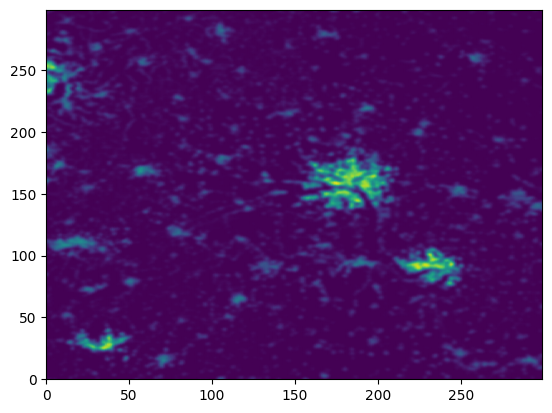

In [6]:
# plot population

BINS = 300
BLUR = 1

fig, ax = plt.subplots()
data = np.histogram2d(xlist, ylist, weights = weight, bins=BINS)[0]
data = gaussian_filter(data, sigma=BLUR)
plt.pcolormesh(data.T, shading='gouraud')
fig.canvas.draw()

100%|██████████| 980/980 [01:16<00:00, 12.85it/s]


Number of Inhabitants:  1846429


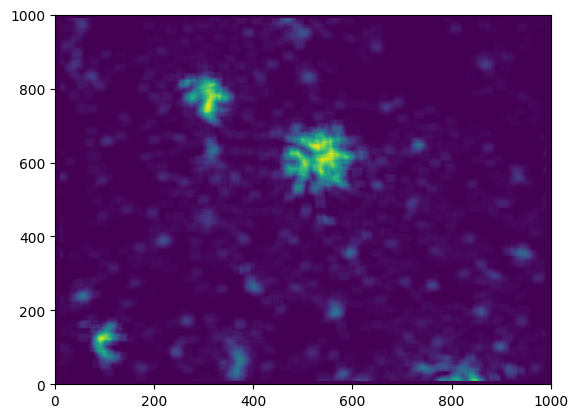

In [21]:
GRIDSIZE = 500
POPULATIONGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)]

lat_step = (maxlat - minlat) / GRIDSIZE
lon_step = (maxlon - minlon) / GRIDSIZE

for x, y, w in zip(xlist, ylist, weight):
      row = int((x - minlat) // lat_step)
      col = int((y - minlon) // lon_step)
      if row < GRIDSIZE and col < GRIDSIZE:
        POPULATIONGRID[row][col] += int(w)

# Blurr 2d list and keep total sum (Totalpopulation) the same (ChatGPT)
def blur_2d_list(input_list, k):
    kernel = [[1/(k*k)]*k for _ in range(k)]  # Define blurring kernel

    output_list =np.zeros((GRIDSIZE, GRIDSIZE))  # Initialize output list

    # Perform convolution operation
    for i in tqdm(range(k//2, GRIDSIZE-k//2)):
        for j in range(k//2, GRIDSIZE-k//2):

            patch = [input_list[x][j-k//2:j+k//2+1] for x in range(i-k//2, i+k//2+1)]

            patch_sum = np.sum(patch)
            output_list[i][j] = patch_sum * kernel[k//2][k//2]


    return output_list


TOTALPOP = np.sum(POPULATIONGRID)
POPULATIONGRID = blur_2d_list(POPULATIONGRID, 20)

# sanity check

print("Number of Inhabitants: ", TOTALPOP)

plt.pcolormesh(POPULATIONGRID)
plt.show()

Read in Neighbours and put them on the same grid

In [8]:
# calculate some stats
import math as m
import haversine as hs 

diagonal = hs.haversine((maxlat, maxlon), (minlat, minlon))
side = diagonal / m.sqrt(2)

# Maßstab berechnen
onepxlength = side / GRIDSIZE # length of one pixel in grid in KM

print("One Pixel in m:", int(onepxlength * 1000))
print("Square side Length in KM: ", int(side))

One Pixel in m: 222
Square side Length in KM:  111


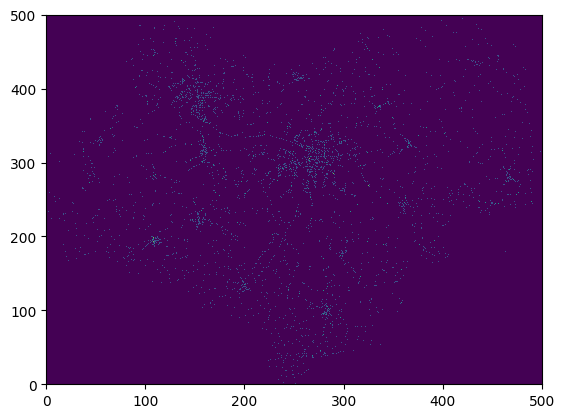

In [9]:
latlist = df_coordinates["stop_lat"].tolist()
lonlist = df_coordinates["stop_lon"].tolist()

STOPSGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)] # create grid thats 0-99


for lat, lon in zip(latlist, lonlist):
    row = int((lat - minlat) // lat_step)
    col = int((lon - minlon) // lon_step)
    if row < GRIDSIZE and col < GRIDSIZE:
        STOPSGRID[row][col] += 1

plt.pcolormesh(STOPSGRID)
plt.show()

3


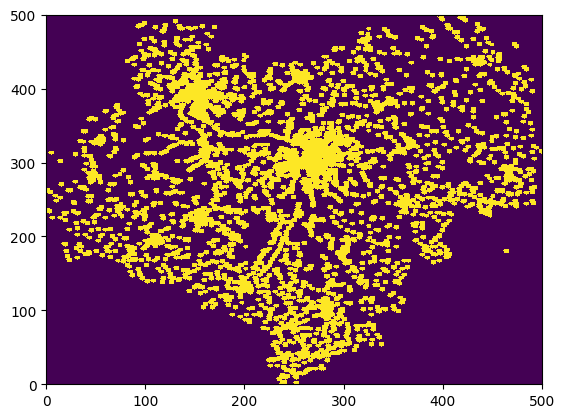

868061.7239757035
47.0130031523391


In [10]:
def convolve_stopgrid(radius): # radius in m

    # radius in px, add 1 for good measure
    radius_px = m.floor(radius / (onepxlength * 1000)) + 1
    
    print(radius_px)

    circlegrid =  [[0 for i in range(radius_px * 2)] for j in range (radius_px * 2)]

    middle = GRIDSIZE / 2

    for x in range(radius_px * 2):
        for y in range(radius_px * 2):
            deltax = radius_px - x
            deltay = radius_px - y

            # calculate distance using pytagoras
            d = m.sqrt((deltax * deltax) + (deltay * deltay))

            if d <= radius_px:
                circlegrid[x][y] = 1
            else:
                circlegrid[x][y] = 0

    convolved_stopgrid = signal.fftconvolve(STOPSGRID, circlegrid, mode = "same")


    return convolved_stopgrid

CONVOLVED = convolve_stopgrid(radius = 500)
CONVOLVED = np.where(CONVOLVED>0 + 10e-3, 1, 0) # so we dont double count pixels which are in range of multiple stops. set every pixel greater than 1 to 1 and all other ones to 0. Because of float error we need a small corrector

plt.pcolormesh(CONVOLVED)
plt.show()
# convert to list and get final number
people = 0
for x in range(GRIDSIZE):
    for y in range(GRIDSIZE):
        if (CONVOLVED[x][y] >= 1):
            people += POPULATIONGRID[x][y]
            
print(people)
print(people / TOTALPOP * 100)  